In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
dataset_X = []
dataset_Y = []

In [3]:
def calc_map_and_save_out(rgb, band, region, name):
    global dataset_X, dataset_Y
    colored_roi = colored[region[0][0]:region[0][1], region[1][0]:region[1][1]]
    
    heatmap = band[region[0][0]:region[0][1], region[1][0]:region[1][1]]
    heatmap[heatmap < 240] = 0
    heatmap = cv2.GaussianBlur(heatmap,(5,5),0)

    #cv2.imwrite(f"{name}_in.jpg", colored_roi)
    #cv2.imwrite(f"{name}_out.jpg", heatmap)

    dataset_X.append(colored_roi)
    dataset_Y.append(heatmap)

In [4]:
b1 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B1.bmp", 0)
b2 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B2.bmp", 0)
b3 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B3.bmp", 0)
b4 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B4.bmp", 0)
b5 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B5.bmp", 0)
b6 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B6.bmp", 0)
b7 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B7.bmp", 0)
b8 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B8.bmp", 0)
b8a = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B8A.bmp", 0)
b9 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B9.bmp", 0)
b10 = cv2.imread("./img/S2B_MSIL1C_20220326T090609_N0400_R050_T35TNL_20220329T104039_B10.bmp", 0)

In [5]:
colored = np.dstack([b4, b3, b2]).astype(np.uint8)

In [6]:
colored.shape

(873, 1318, 3)

In [7]:
size = 100

In [8]:
for i in range(int(colored.shape[0]/size)):
  for j in range(int(colored.shape[1]/size)):
    startX = i*size
    endX = (i+1)*size
    startY = j*size
    endY = (j+1)*size

    if endX > colored.shape[0] or endY > colored.shape[1]:
      continue
    
    calc_map_and_save_out(colored, b7, [[startX, endX], [startY, endY]], f"out/{i}_{j}")

In [9]:
import torch
from torch import nn
from torch import optim

In [10]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=1000
        )
        self.encoder_output_layer = nn.Linear(
            in_features=1000, out_features=1000
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=1000, out_features=1000
        )
        self.decoder_output_layer = nn.Linear(
            in_features=1000, out_features=10000
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [11]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=3*10000, output_shape=10000).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [12]:
dataset_X_flat = np.array(dataset_X).reshape((-1, 3*10000))
dataset_Y_flat = np.array(dataset_Y).reshape((-1, 10000))

In [13]:
dataset_X_flat.shape

(104, 30000)

In [14]:
epoches = 10
for epoch in range(epoches):
    loss = 0
    
    output_real = torch.tensor(dataset_Y_flat)/255

    # reshape mini-batch data to [N, 784] matrix
    # load it to the active device
    input = torch.tensor(dataset_X_flat)/255
    
    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
    optimizer.zero_grad()
    
    # compute reconstructions
    outputs = model(input)
    
    # compute training reconstruction loss
    print(outputs.shape)
    print(output_real.shape)
    train_loss = criterion(outputs, output_real)
    
    # compute accumulated gradients
    train_loss.backward()
    
    # perform parameter update based on current gradients
    optimizer.step()
    
    # add the mini-batch training loss to epoch loss
    loss += train_loss.item()
    
    # compute the epoch training loss
    #loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epoches, loss))

torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 1/10, loss = 0.014902
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 2/10, loss = 8.493649
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 3/10, loss = 0.049022
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 4/10, loss = 0.025204
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 5/10, loss = 0.016556
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 6/10, loss = 0.015391
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 7/10, loss = 0.015148
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 8/10, loss = 0.015095
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 9/10, loss = 0.014976
torch.Size([104, 10000])
torch.Size([104, 10000])
epoch : 10/10, loss = 0.014878


In [15]:
input = torch.tensor(dataset_X_flat)/255
out = model(input[0])

In [20]:
np_out = out.cpu().detach().numpy()

In [23]:
np_out = np_out*255
np_out = np_out.astype("int")

In [26]:
np_out = np_out.reshape((100, 100))

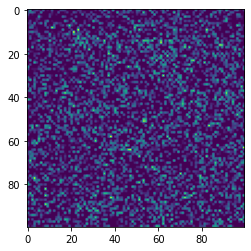

In [27]:
plt.imshow(np_out)
plt.show()

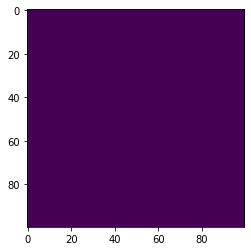

In [28]:
plt.imshow(dataset_Y[0])
plt.show()